In [21]:
#Import libraries 
import numpy as np
import matplotlib.pyplot as plt
import hvplot.pandas as hvplot
import pandas as pd 
import requests
import csv

#Define the file path
file = "./Data/time_series_covid19_confirmed_US.csv"
#Read the csv
covid_df = pd.read_csv(file)
covid_df.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,19732,19759,19759,19759,19759,19759,19759,19759,19790,19790
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,69641,69767,69767,69767,69767,69767,69767,69767,69860,69860
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,7451,7474,7474,7474,7474,7474,7474,7474,7485,7485
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,8067,8087,8087,8087,8087,8087,8087,8087,8091,8091
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,18616,18673,18673,18673,18673,18673,18673,18673,18704,18704


In [22]:
#Cleaning the data
clean_df = covid_df.loc[(covid_df["Long_"] != 0.0) & (covid_df["Lat"] != 0.0)]
clean_df = clean_df.dropna()

clean_df.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,19732,19759,19759,19759,19759,19759,19759,19759,19790,19790
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,69641,69767,69767,69767,69767,69767,69767,69767,69860,69860
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,7451,7474,7474,7474,7474,7474,7474,7474,7485,7485
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,8067,8087,8087,8087,8087,8087,8087,8087,8091,8091
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,18616,18673,18673,18673,18673,18673,18673,18673,18704,18704


In [23]:
#Example
minnesota_df = clean_df.loc[covid_df["Province_State"] == "Minnesota"]
minnesota_df.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
1369,84027001,US,USA,840,27001.0,Aitkin,Minnesota,US,46.609620,-93.411683,...,3679,3679,3696,3696,3696,3696,3696,3696,3696,3702
1370,84027003,US,USA,840,27003.0,Anoka,Minnesota,US,45.274760,-93.246046,...,118906,118906,119208,119208,119208,119208,119208,119208,119208,119415
1371,84027005,US,USA,840,27005.0,Becker,Minnesota,US,46.934794,-95.671581,...,10456,10456,10489,10489,10489,10489,10489,10489,10489,10509
1372,84027007,US,USA,840,27007.0,Beltrami,Minnesota,US,47.973735,-94.937321,...,14326,14326,14371,14371,14371,14371,14371,14371,14371,14406
1373,84027009,US,USA,840,27009.0,Benton,Minnesota,US,45.698050,-93.995141,...,16981,16981,17025,17025,17025,17025,17025,17025,17025,17064


In [24]:
minnesota_map = minnesota_df.hvplot.points(
    "Long_",
    "Lat",
    geo = True,
    color="Admin2"
    
)
minnesota_map

:Points   [Long_,Lat]   (Admin2)

<Axes: xlabel='Admin2'>

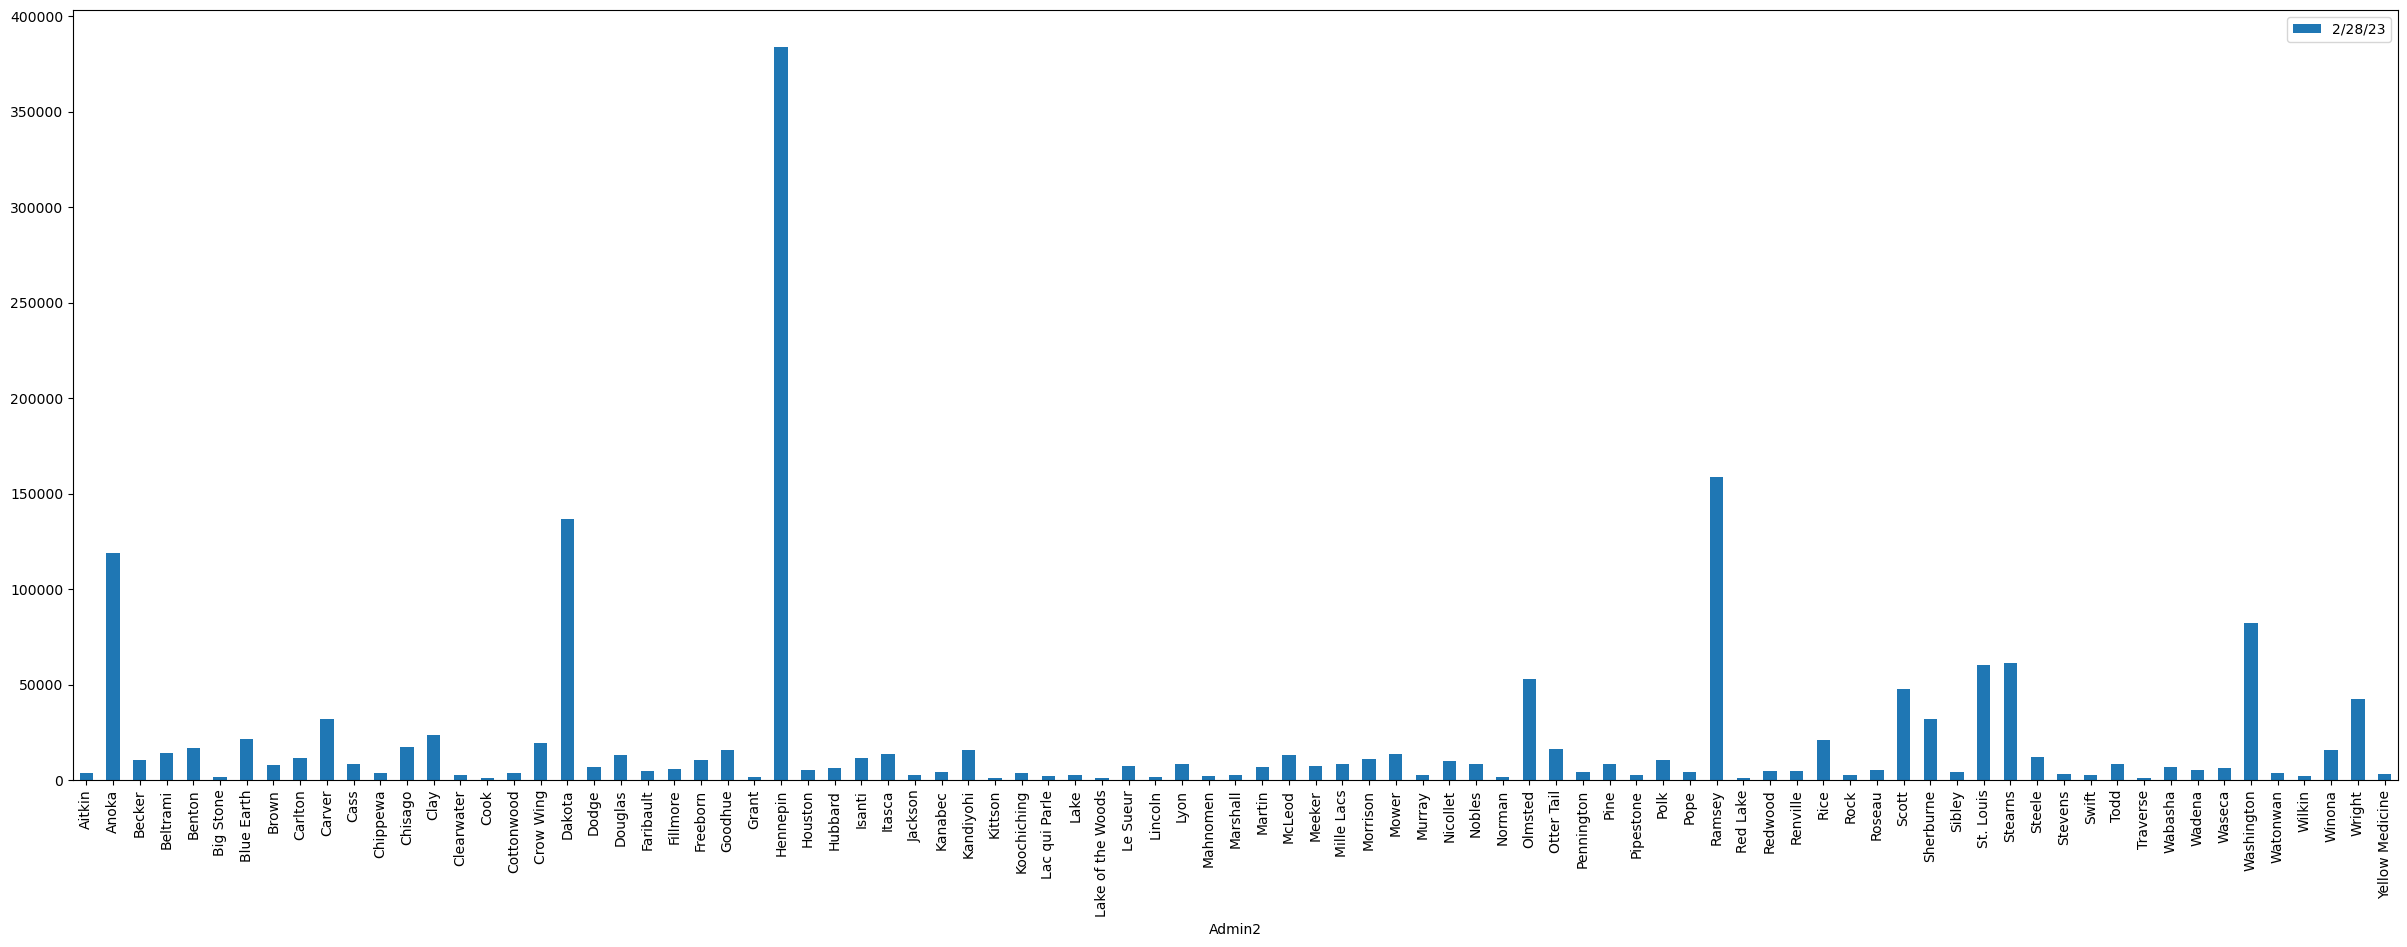

In [25]:
minnesota_df.plot("Admin2","2/28/23",kind="bar",figsize=(30,10))


In [26]:
#Cleaning code

In [27]:
#Viktor

In [28]:
#Viktor

In [29]:
#Samantha

In [30]:
#Samantha

In [31]:
#Nicholas

In [32]:
#Nicholas

In [33]:
#Mysee's state: Wisconsin
wisconsin_df = clean_df.loc[covid_df["Province_State"] == "Wisconsin"]
wisconsin_df.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
3243,84055001,US,USA,840,55001.0,Adams,Wisconsin,US,43.969747,-89.767828,...,5840,5842,5843,5844,5844,5844,5849,5852,5854,5855
3244,84055003,US,USA,840,55003.0,Ashland,Wisconsin,US,46.319569,-90.678371,...,4154,4157,4159,4160,4160,4160,4164,4169,4169,4171
3245,84055005,US,USA,840,55005.0,Barron,Wisconsin,US,45.423727,-91.848336,...,16100,16106,16109,16116,16116,16116,16124,16127,16130,16134
3246,84055007,US,USA,840,55007.0,Bayfield,Wisconsin,US,46.528688,-91.197167,...,4384,4385,4385,4386,4386,4386,4387,4387,4387,4388
3247,84055009,US,USA,840,55009.0,Brown,Wisconsin,US,44.452655,-88.004118,...,102838,102895,102933,102960,102960,102960,103009,103053,103098,103132


In [34]:
wisconsin_map = wisconsin_df.hvplot.points(
    "Long_",
    "Lat",
    geo = True,
    color="Admin2"
)
wisconsin_map

:Points   [Long_,Lat]   (Admin2)

In [35]:
# Code example from Micah Springer; see the rest of the code that was not used in Slack from August 8, 2024. Purpose: Remove excess headers and to transpose data to read per state and not per time point.
states_yearly_df = clean_df[["Province_State","1/31/20", "2/28/20", "3/31/20", "4/30/20", "5/31/20", "6/30/20", "7/31/20", "8/31/20", "9/30/20", "10/31/20", "11/30/20", "12/31/20", "1/31/21", "2/28/21", "3/31/21", "4/30/21", "5/31/21", "6/30/21", "7/31/21", "8/31/21", "9/30/21", "10/31/21", "11/30/21", "12/31/21", "1/31/22", "2/28/22", "3/31/22", "4/30/22", "5/31/22", "6/30/22", "7/31/22", "8/31/22", "9/30/22", "10/31/22", "11/30/22", "12/31/22", "1/31/23", "2/28/23"]] # Modified to match Year_2020_2023_date
states_yearly_df = states_yearly_df.groupby(states_yearly_df["Province_State"]).sum()
states_yearly_df = states_yearly_df.transpose()
Timepoints = ["1/31/20", "2/28/20", "3/31/20", "4/30/20", "5/31/20", "6/30/20", "7/31/20", "8/31/20", "9/30/20", "10/31/20", "11/30/20", "12/31/20", "1/31/21", "2/28/21", "3/31/21", "4/30/21", "5/31/21", "6/30/21", "7/31/21", "8/31/21", "9/30/21", "10/31/21", "11/30/21", "12/31/21", "1/31/22", "2/28/22", "3/31/22", "4/30/22", "5/31/22", "6/30/22", "7/31/22", "8/31/22", "9/30/22", "10/31/22", "11/30/22", "12/31/22", "1/31/23", "2/28/23"] # Modified to match Year_2020_2023_date
states_yearly_df["Timepoints"] = Timepoints
states_yearly_df

Province_State,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming,Timepoints
1/31/20,0,0,1,0,3,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1/31/20
2/28/20,0,0,1,0,13,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,2/28/20
3/31/20,1063,129,1289,489,8011,2837,3051,319,495,6739,...,1894,3809,818,282,1249,5158,162,1412,109,3/31/20
4/30/20,7187,360,7655,3113,50711,19755,27238,4709,4323,33683,...,11653,23369,4308,863,15847,14267,1125,6854,559,4/30/20
5/31/20,18200,484,19936,7065,113865,29001,41967,9447,8801,56079,...,23015,53526,8758,976,44607,21634,2010,18403,903,5/31/20
6/30/20,38477,1142,79227,20056,240802,36265,46310,11436,10327,152289,...,43225,165267,17968,1202,62787,33414,2900,28659,1487,6/30/20
7/31/20,88266,3700,174010,40957,506927,51522,49567,14569,12126,469816,...,103072,416421,31985,1407,89888,57468,6579,52940,2726,7/31/20
8/31/20,126500,6141,201835,60320,713644,60919,52769,17144,13992,622471,...,151160,650193,41725,1616,120594,75266,10249,75603,3777,8/31/20
9/30/20,154772,8810,218507,81786,821473,76699,57399,20122,15326,704786,...,191439,779151,59778,1744,148271,89173,15850,122274,5948,9/30/20
10/31/20,193613,16301,245946,110079,940262,124988,71066,24860,17266,800607,...,252697,926132,93100,2171,181190,110451,24460,237869,13298,10/31/20


In [36]:
# Using Micah's code, clean up the data frame but do not dispose in order to track sum of each state per time point.

# Attempt 1.2 with help from Xpert Learning Assistant
USA_rollingCOVID19totalINFECTIONSperSTATE_df = clean_df[["Province_State", "1/31/20", "2/28/20", "3/31/20", "4/30/20", "5/31/20", "6/30/20", "7/31/20", "8/31/20", "9/30/20", "10/31/20", "11/30/20", "12/31/20", "1/31/21", "2/28/21", "3/31/21", "4/30/21", "5/31/21", "6/30/21", "7/31/21", "8/31/21", "9/30/21", "10/31/21", "11/30/21", "12/31/21", "1/31/22", "2/28/22", "3/31/22", "4/30/22", "5/31/22", "6/30/22", "7/31/22", "8/31/22", "9/30/22", "10/31/22", "11/30/22", "12/31/22", "1/31/23", "2/28/23"]]
USA_rollingCOVID19totalINFECTIONSperSTATE_df.set_index("Province_State", inplace=True)
USA_rollingCOVID19totalINFECTIONSperSTATE_df = USA_rollingCOVID19totalINFECTIONSperSTATE_df.groupby("Province_State").sum()
# Add column for US states where length is total 52 (including header and add the two provinces: DC and Puerto Rico)
USstatesANDprovince = ["Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado", "Connecticut", "Delaware", "District of Columbia", "Florida", "Georgia", "Hawaii", "Idaho", "Illinois", "Indiana", "Iowa", "Kansas", "Kentucky", "Louisiana", "Maine", "Maryland", "Massachusetts", "Michigan", "Minnesota", "Mississippi", "Missouri", "Montana", "Nebraska", "Nevada", "New Hampshire", "New Jersey", "New Mexico", "New York", "North Carolina", "North Dakota", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Puerto Rico", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Vermont", "Virginia", "Washington", "West Virginia", "Wisconsin", "Wyoming"]
USA_rollingCOVID19totalINFECTIONSperSTATE_df["Province_State"] = USstatesANDprovince
USA_rollingCOVID19totalINFECTIONSperSTATE_df



,1/31/20,2/28/20,3/31/20,4/30/20,5/31/20,6/30/20,7/31/20,8/31/20,9/30/20,10/31/20,...,6/30/22,7/31/22,8/31/22,9/30/22,10/31/22,11/30/22,12/31/22,1/31/23,2/28/23,Province_State
Province_State,,,,,,,,,,,,,,,,,,,,,
Alabama,0,0,1063,7187,18200,38477,88266,126500,154772,193613,...,1357266,1424411,1479605,1522135,1534287,1549285,1568934,1610535,1638348,Alabama
Alaska,0,0,129,360,484,1142,3700,6141,8810,16301,...,271298,282383,292819,296372,298352,299863,301426,304362,307067,Alaska
Arizona,1,1,1289,7655,19936,79227,174010,201835,218507,245946,...,2125567,2196429,2254374,2271560,2287886,2337547,2378334,2398200,2434631,Arizona
Arkansas,0,0,489,3113,7065,20056,40957,60320,81786,110079,...,837657,874463,902020,920355,928315,936982,952804,963552,971297,Arkansas
California,3,13,8011,50711,113865,240802,506927,713644,821473,940262,...,10133662,10705458,11096362,11265459,11368828,11537253,11830499,11997480,12093166,California
Colorado,0,0,2837,19755,29001,36265,51522,60919,76699,124988,...,1552748,1603055,1630855,1654626,1674696,1708059,1734562,1748759,1760233,Colorado
Connecticut,0,0,3051,27238,41967,46310,49567,52769,57399,71066,...,826329,851855,872274,893986,910179,923919,945789,963645,971983,Connecticut
Delaware,0,0,319,4709,9447,11436,14569,17144,20122,24860,...,284062,293025,301673,307563,312284,315842,320766,324757,329219,Delaware
District of Columbia,0,0,495,4323,8801,10327,12126,13992,15326,17266,...,156802,162519,166166,168514,169709,171317,173386,176012,177504,District of Columbia


In [37]:
# Used for test before scale up from Micah's code: Year_2020_dates = ["1/31/20", "2/28/20", "3/31/20", "4/30/20", "5/31/20", "6/30/20", "7/31/20", "8/31/20", "9/30/20", "10/31/20", "11/30/20", "12/31/20"]
Year_2020_2023_dates = ["1/31/20", "2/28/20", "3/31/20", "4/30/20", "5/31/20", "6/30/20", "7/31/20", "8/31/20", "9/30/20", "10/31/20", "11/30/20", "12/31/20", "1/31/21", "2/28/21", "3/31/21", "4/30/21", "5/31/21", "6/30/21", "7/31/21", "8/31/21", "9/30/21", "10/31/21", "11/30/21", "12/31/21", "1/31/22", "2/28/22", "3/31/22", "4/30/22", "5/31/22", "6/30/22", "7/31/22", "8/31/22", "9/30/22", "10/31/22", "11/30/22", "12/31/22", "1/31/23", "2/28/23"]
test_WI_df = wisconsin_df[["Admin2", "1/31/20", "2/28/20", "3/31/20", "4/30/20", "5/31/20", "6/30/20", "7/31/20", "8/31/20", "9/30/20", "10/31/20", "11/30/20", "12/31/20", "1/31/21", "2/28/21", "3/31/21", "4/30/21", "5/31/21", "6/30/21", "7/31/21", "8/31/21", "9/30/21", "10/31/21", "11/30/21", "12/31/21", "1/31/22", "2/28/22", "3/31/22", "4/30/22", "5/31/22", "6/30/22", "7/31/22", "8/31/22", "9/30/22", "10/31/22", "11/30/22", "12/31/22", "1/31/23", "2/28/23"]]
test_WI_df = test_WI_df.set_index("Admin2")
transpose_test_WI_df = test_WI_df.transpose()
transpose_test_WI_df["timepoints"]=Year_2020_2023_dates
transpose_test_WI_df

Admin2,Adams,Ashland,Barron,Bayfield,Brown,Buffalo,Burnett,Calumet,Chippewa,Clark,...,Vilas,Walworth,Washburn,Washington,Waukesha,Waupaca,Waushara,Winnebago,Wood,timepoints
1/31/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1/31/20
2/28/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2/28/20
3/31/20,0,1,0,2,9,1,0,1,8,3,...,3,6,0,40,101,1,0,11,2,3/31/20
4/30/20,4,2,6,3,1057,4,0,13,22,20,...,4,161,1,98,336,8,2,53,2,4/30/20
5/31/20,4,2,17,3,2319,6,1,76,56,32,...,7,395,2,252,696,41,8,244,10,5/31/20
6/30/20,19,3,34,3,2873,7,3,108,84,72,...,10,607,4,368,1175,113,25,669,51,6/30/20
7/31/20,69,15,228,18,3919,41,13,236,208,168,...,29,1179,21,805,3488,350,99,1014,216,7/31/20
8/31/20,112,34,370,45,5376,64,40,502,347,241,...,105,1703,65,1622,5568,663,154,1528,458,8/31/20
9/30/20,259,127,490,115,9536,143,205,1282,585,416,...,237,2629,114,2697,7604,1122,385,4134,857,9/30/20
10/31/20,616,310,1313,277,16484,337,343,2886,1976,1078,...,658,3901,270,5208,14462,2867,1104,9803,2040,10/31/20


Text(0.5, 1.0, "Wisconsin's Total Confirmed COVID19 Cases by County from January 2020 to February 2023")

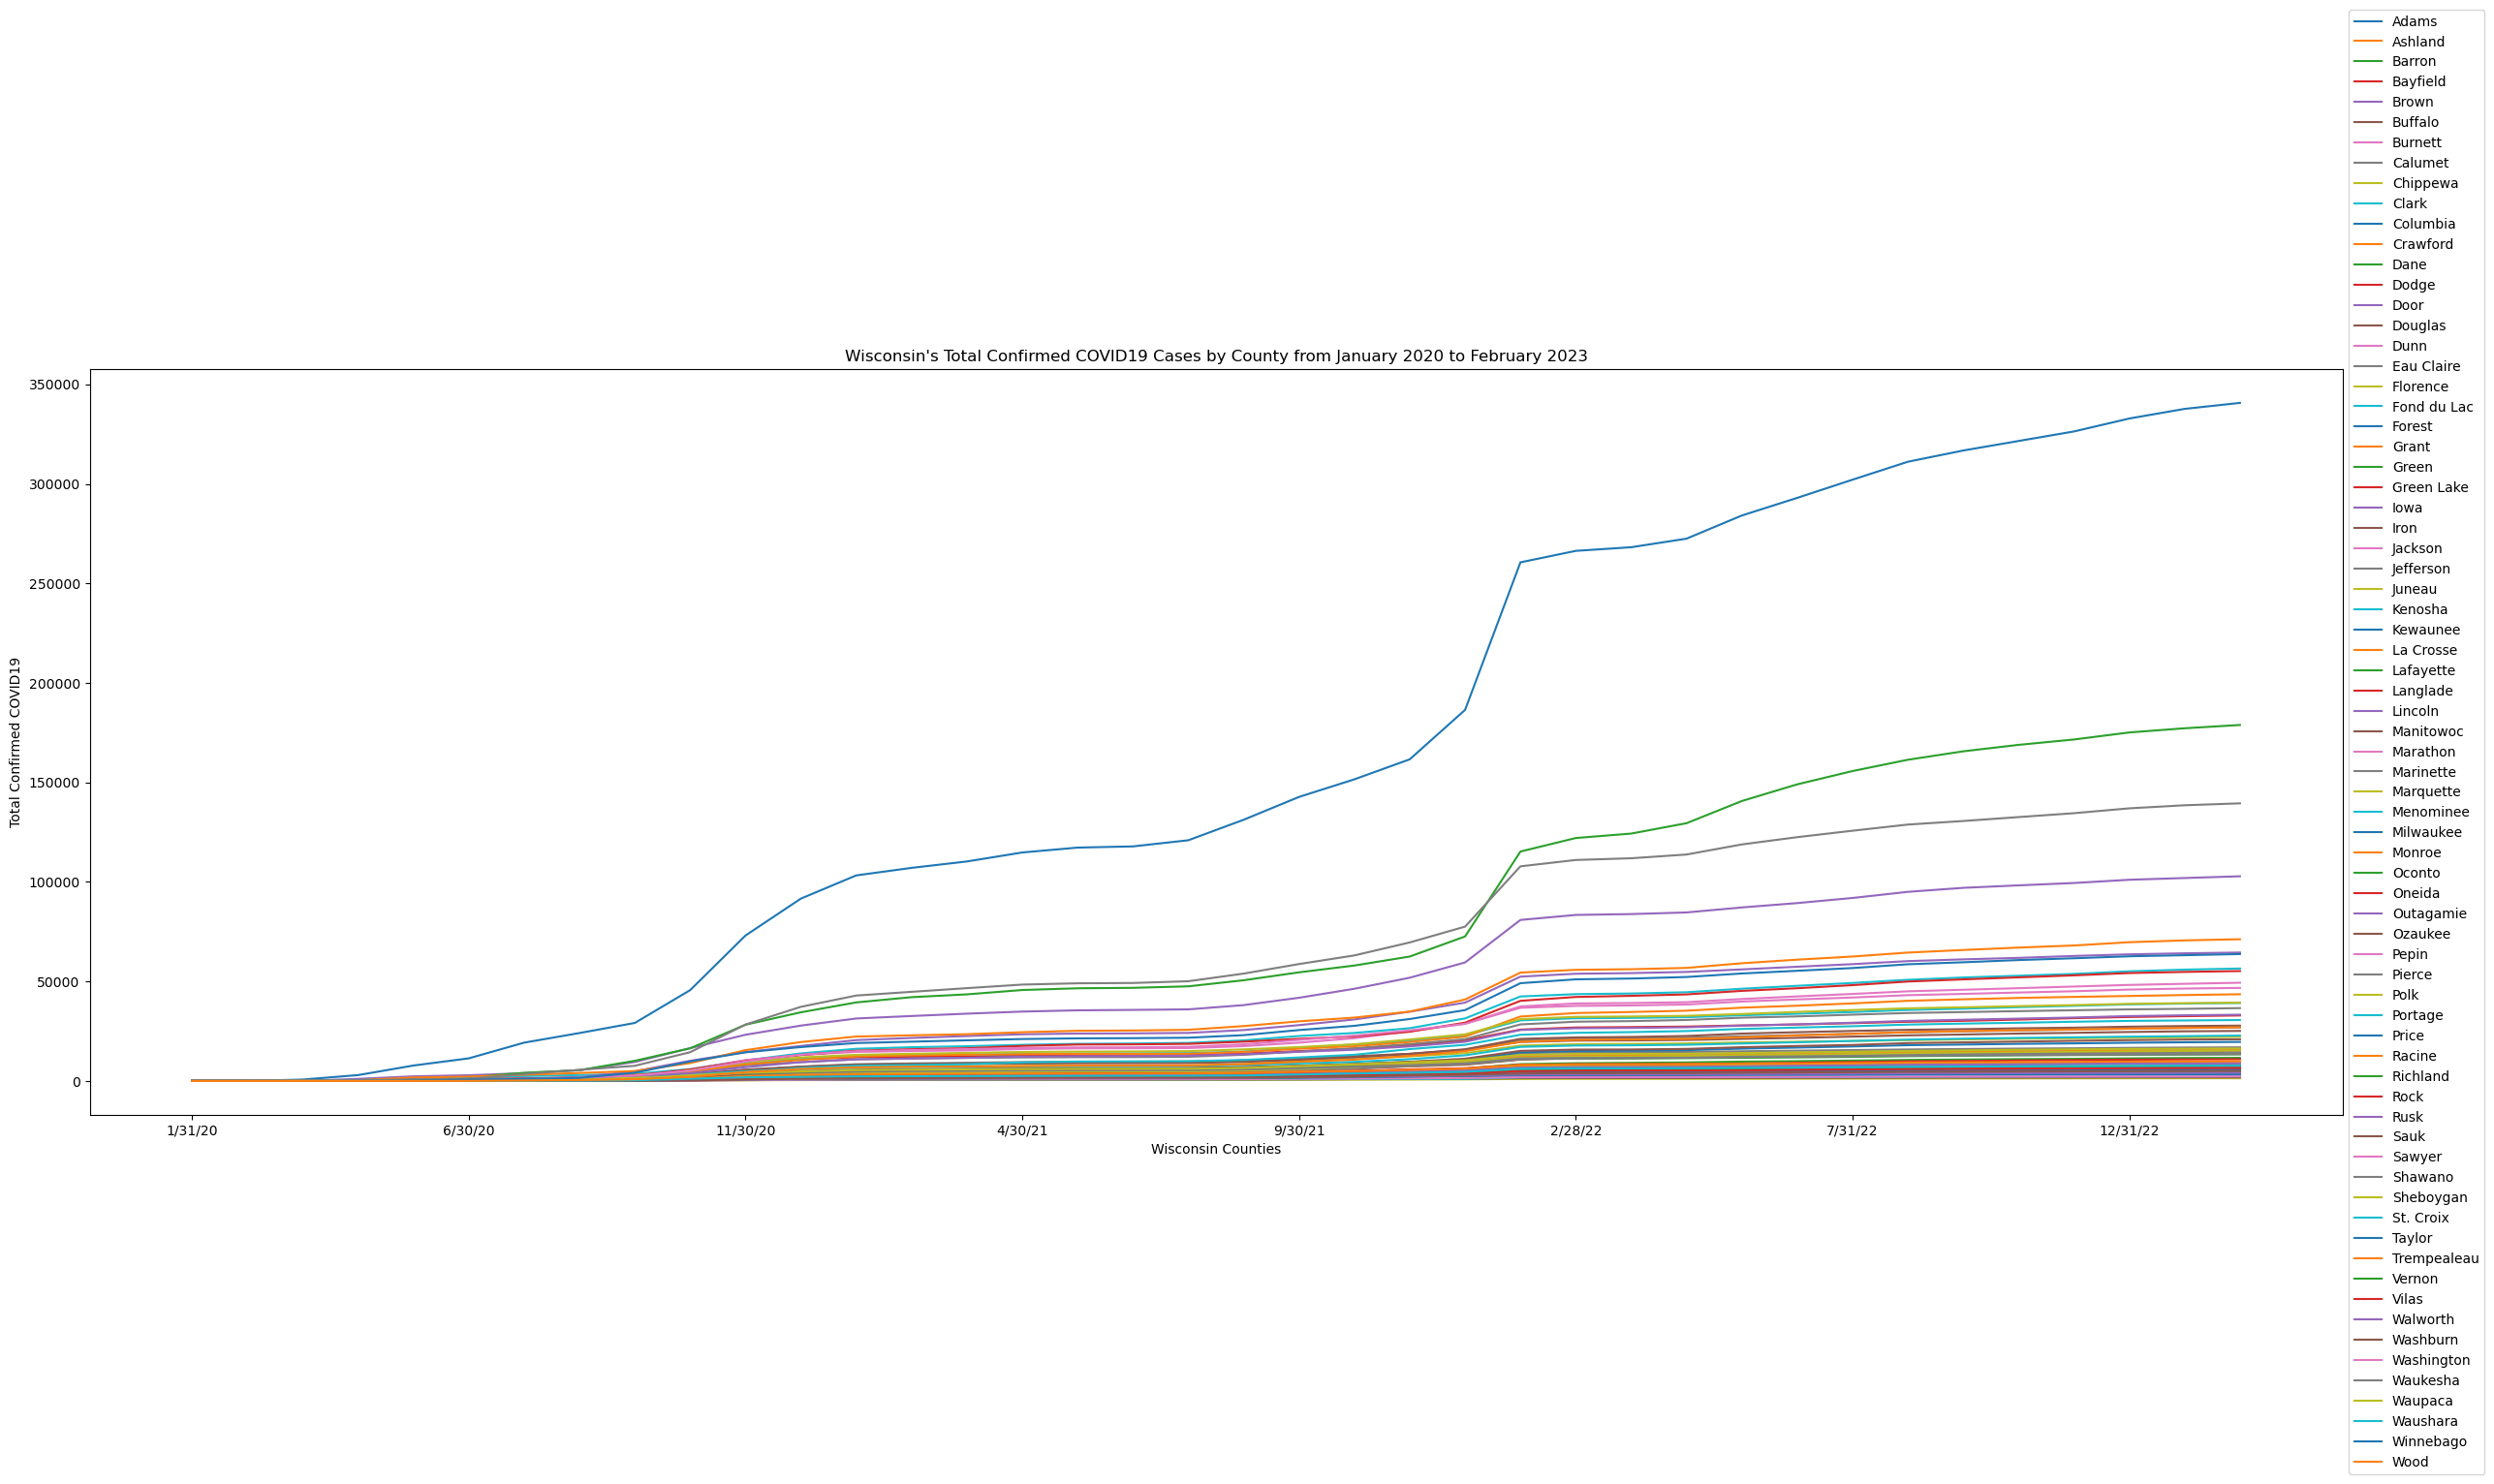

In [38]:
transpose_test_WI_df.plot(x="timepoints", y=["Adams", "Ashland", "Barron", "Bayfield", "Brown", "Buffalo", "Burnett", "Calumet", "Chippewa", "Clark", "Columbia", "Crawford", "Dane", "Dodge", "Door", "Douglas", "Dunn", "Eau Claire", "Florence", "Fond du Lac", "Forest", "Grant", "Green", "Green Lake", "Iowa", "Iron", "Jackson", "Jefferson", "Juneau", "Kenosha", "Kewaunee", "La Crosse", "Lafayette", "Langlade", "Lincoln", "Manitowoc", "Marathon", "Marinette", "Marquette", "Menominee", "Milwaukee", "Monroe", "Oconto", "Oneida", "Outagamie","Ozaukee", "Pepin", "Pierce", "Polk", "Portage", "Price", "Racine", "Richland", "Rock", "Rusk", "Sauk", "Sawyer", "Shawano", "Sheboygan", "St. Croix", "Taylor", "Trempealeau", "Vernon", "Vilas", "Walworth", "Washburn", "Washington", "Waukesha", "Waupaca", "Waushara", "Winnebago", "Wood"], kind="line", figsize=(30,10))
plt.xlabel("Wisconsin Counties")
plt.ylabel("Total Confirmed COVID19")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.title("Wisconsin's Total Confirmed COVID19 Cases by County from January 2020 to February 2023")










Text(0.5, 1.0, "Wisconsin's Total Confirmed COVID19 Cases by County on February 28, 2023")

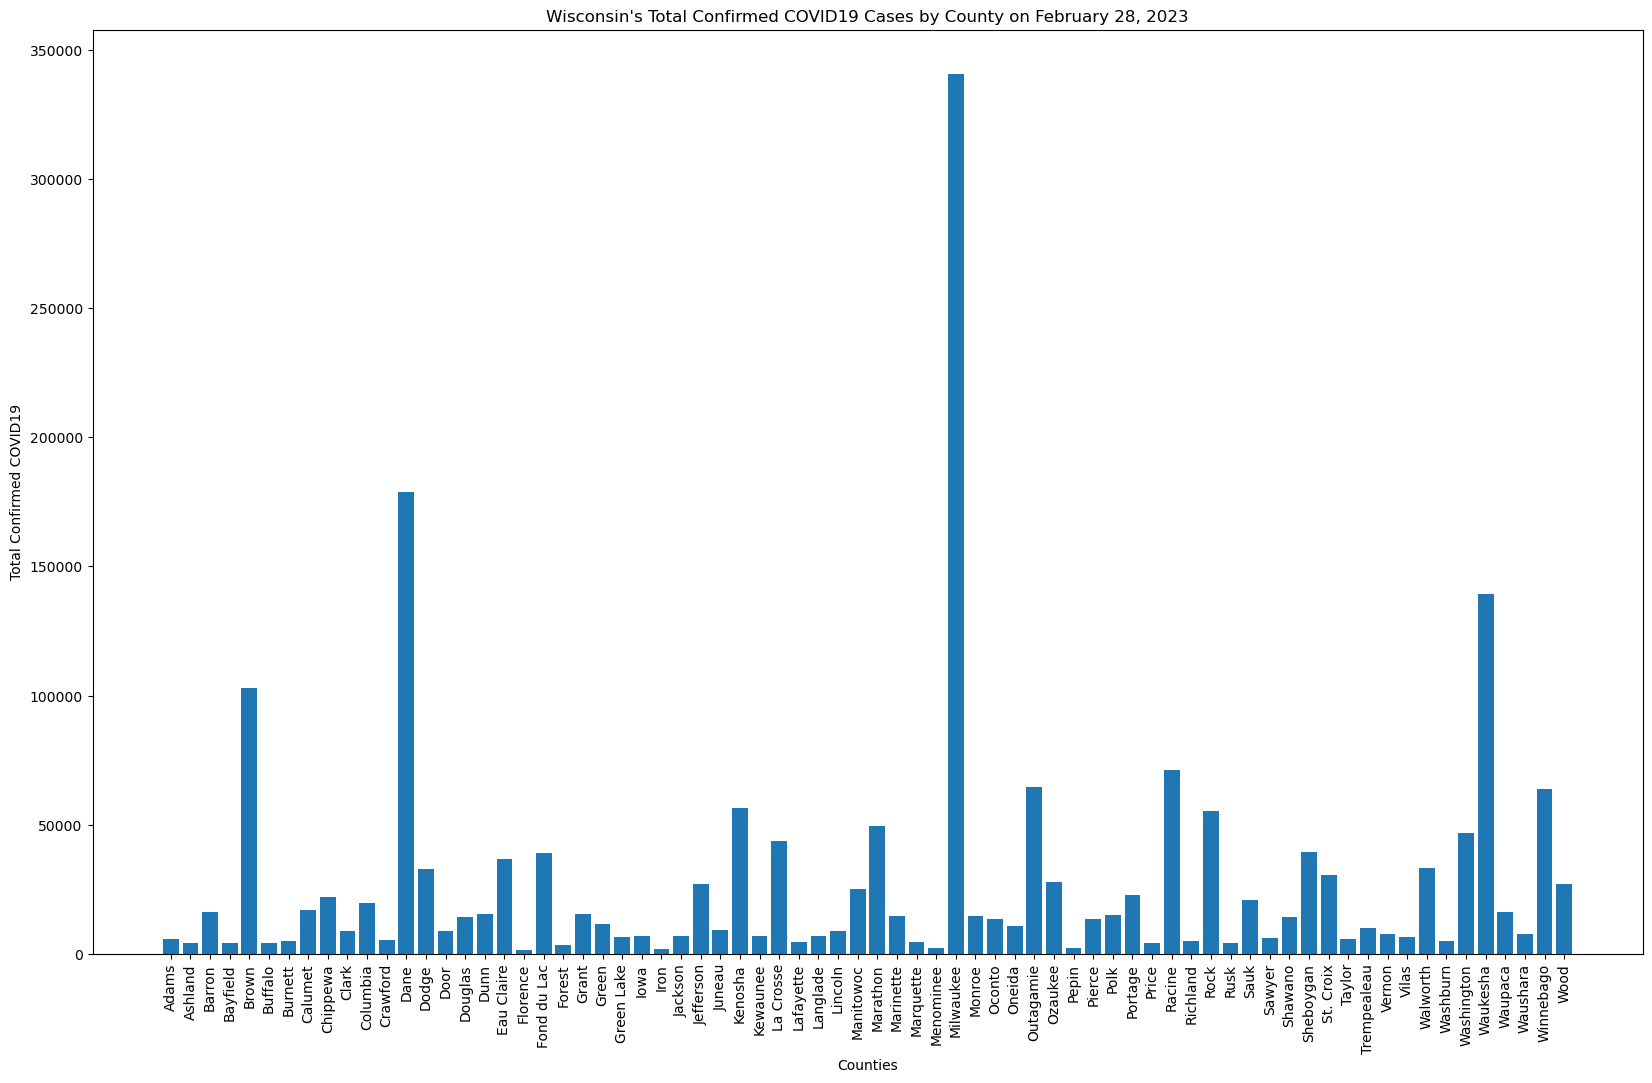

In [39]:
# Adjust size of bar chart
plt.figure(figsize=(20,12))
# Plot running total of all Wisconsin counties
plt.bar(wisconsin_df["Admin2"], wisconsin_df["2/28/23"])
# Add and format labels
plt.xlabel("Counties")
plt.xticks(rotation=90) # Rotate x-axis ticks for easier reading
plt.ylabel("Total Confirmed COVID19")
plt.title("Wisconsin's Total Confirmed COVID19 Cases by County on February 28, 2023")

In [43]:
# Repeat cell 14 and cell 18 for each state
# TEMPLATE FROM 14: wisconsin_df = clean_df.loc[covid_df["Province_State"] == "Wisconsin"]
# TEMPLATE FROM 33: USA_rollingCOVID19totalINFECTIONSperSTATE_df = clean_df[["Province_State", "1/31/20", "2/28/20", "3/31/20", "4/30/20", "5/31/20", "6/30/20", "7/31/20", "8/31/20", "9/30/20", "10/31/20", "11/30/20", "12/31/20", "1/31/21", "2/28/21", "3/31/21", "4/30/21", "5/31/21", "6/30/21", "7/31/21", "8/31/21", "9/30/21", "10/31/21", "11/30/21", "12/31/21", "1/31/22", "2/28/22", "3/31/22", "4/30/22", "5/31/22", "6/30/22", "7/31/22", "8/31/22", "9/30/22", "10/31/22", "11/30/22", "12/31/22", "1/31/23", "2/28/23"]]

# test_WI_df = wisconsin_df[["Admin2", "1/31/20", "2/28/20", "3/31/20", "4/30/20", "5/31/20", "6/30/20", "7/31/20", "8/31/20", "9/30/20", "10/31/20", "11/30/20", "12/31/20", "1/31/21", "2/28/21", "3/31/21", "4/30/21", "5/31/21", "6/30/21", "7/31/21", "8/31/21", "9/30/21", "10/31/21", "11/30/21", "12/31/21", "1/31/22", "2/28/22", "3/31/22", "4/30/22", "5/31/22", "6/30/22", "7/31/22", "8/31/22", "9/30/22", "10/31/22", "11/30/22", "12/31/22", "1/31/23", "2/28/23"]]
# test_WI_df = test_WI_df.set_index("Admin2")
# transpose_test_WI_df = test_WI_df.transpose()
# transpose_test_WI_df["timepoints"]=Year_2020_2023_dates
# transpose_test_WI_df

# Attempt 1.2 with help from Xpert Learning Assistant; copied from previous code. Adjusted to be just March 9, 2023
USA_rollingCOVID19totalINFECTIONSperSTATE_2023_March_9_df = clean_df[["Province_State", "3/9/23"]]
USA_rollingCOVID19totalINFECTIONSperSTATE_2023_March_9_df.set_index("Province_State", inplace=True)
USA_rollingCOVID19totalINFECTIONSperSTATE_2023_March_9_df = USA_rollingCOVID19totalINFECTIONSperSTATE_2023_March_9_df.groupby("Province_State").sum()
# Add column for US states where length is total 52 (including header and add the two provinces: DC and Puerto Rico)
USstatesANDprovince = ["Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado", "Connecticut", "Delaware", "District of Columbia", "Florida", "Georgia", "Hawaii", "Idaho", "Illinois", "Indiana", "Iowa", "Kansas", "Kentucky", "Louisiana", "Maine", "Maryland", "Massachusetts", "Michigan", "Minnesota", "Mississippi", "Missouri", "Montana", "Nebraska", "Nevada", "New Hampshire", "New Jersey", "New Mexico", "New York", "North Carolina", "North Dakota", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Puerto Rico", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Vermont", "Virginia", "Washington", "West Virginia", "Wisconsin", "Wyoming"]
USA_rollingCOVID19totalINFECTIONSperSTATE_2023_March_9_df["Province_State"] = USstatesANDprovince
USA_rollingCOVID19totalINFECTIONSperSTATE_2023_March_9_df

,3/9/23,Province_State
Province_State,,
Alabama,1644533,Alabama
Alaska,307649,Alaska
Arizona,2443514,Arizona
Arkansas,973278,Arkansas
California,12125315,California
Colorado,1764140,Colorado
Connecticut,973386,Connecticut
Delaware,329683,Delaware
District of Columbia,177945,District of Columbia


In [80]:
# test_WI_df = wisconsin_df[["Admin2", "1/31/20", "2/28/20", "3/31/20", "4/30/20", "5/31/20", "6/30/20", "7/31/20", "8/31/20", "9/30/20", "10/31/20", "11/30/20", "12/31/20", "1/31/21", "2/28/21", "3/31/21", "4/30/21", "5/31/21", "6/30/21", "7/31/21", "8/31/21", "9/30/21", "10/31/21", "11/30/21", "12/31/21", "1/31/22", "2/28/22", "3/31/22", "4/30/22", "5/31/22", "6/30/22", "7/31/22", "8/31/22", "9/30/22", "10/31/22", "11/30/22", "12/31/22", "1/31/23", "2/28/23"]]
# test_WI_df = test_WI_df.set_index("Admin2")
# transpose_test_WI_df = test_WI_df.transpose()
# transpose_test_WI_df["timepoints"]=Year_2020_2023_dates
# transpose_test_WI_df


# Step 1: Filter the DataFrame for the specific state
# Step 2: Set index to Province_State
# Step 3: Declare column of interests


# Alabama_df = clean_df.loc[covid_df["Province_State"] == "Alabama"]
# Alaska_df = clean_df.loc[covid_df["Province_State"] == "Alaska"]
# Arizona_df = clean_df.loc[covid_df["Province_State"] == "Arizona"]
# California_df = clean_df.loc[covid_df["Province_State"] == "California"]
# Colorado_df = clean_df.loc[covid_df["Province_State"] == "Colorado"]
# Connecticut_df  = clean_df.loc[covid_df["Province_State"] == "Connecticut"]
# Delaware_df = clean_df.loc[covid_df["Province_State"] == "Delaware"]
# DC_df = clean_df.loc[covid_df["Province_State"] == "District of Columbia"]
# Florida_df = clean_df.loc[covid_df["Province_State"] == "Florida"]
# Georgia_df = clean_df.loc[covid_df["Province_State"] == "Georgia"]
# Hawaii_df = clean_df.loc[covid_df["Province_State"] == "Hawaii"]
# Idaho_df = clean_df.loc[covid_df["Province_State"] == "Idaho"]
# Illinois_df = clean_df.loc[covid_df["Province_State"] == "Illinois"]
# Indiana_df = clean_df.loc[covid_df["Province_State"] == "Indiana"]
# Iowa_df = clean_df.loc[covid_df["Province_State"] == "Iowa"]
# Kansas_df = clean_df.loc[covid_df["Province_State"] == "Kansas"]
# Kentucky_df = clean_df.loc[covid_df["Province_State"] == "Kentucky"]
# Louisiana_df = clean_df.loc[covid_df["Province_State"] == "Louisiana"]
# Maine_df = clean_df.loc[covid_df["Province_State"] == "Maine"]
# Maryland_df = clean_df.loc[covid_df["Province_State"] == "Maryland"]
# Massachusetts_df = clean_df.loc[covid_df["Province_State"] == "Massachusetts"]
# Michigan_ = clean_df.loc[covid_df["Province_State"] == "Michigan"]
Minnesota_df = clean_df.loc[covid_df["Province_State"] == "Minnesota"]
Minnesota_df = Minnesota_df[["Admin2", "1/31/20", "2/28/20", "3/31/20", "4/30/20", "5/31/20", "6/30/20", "7/31/20", "8/31/20", "9/30/20", "10/31/20", "11/30/20", "12/31/20", "1/31/21", "2/28/21", "3/31/21", "4/30/21", "5/31/21", "6/30/21", "7/31/21", "8/31/21", "9/30/21", "10/31/21", "11/30/21", "12/31/21", "1/31/22", "2/28/22", "3/31/22", "4/30/22", "5/31/22", "6/30/22", "7/31/22", "8/31/22", "9/30/22", "10/31/22", "11/30/22", "12/31/22", "1/31/23", "2/28/23"]]
Minnesota_df = Minnesota_df.set_index("Admin2")
Minnesota_df = Minnesota_df.transpose()
Minnesota_df["timepoints"] = Year_2020_2023_dates
# Mississippi_df = clean_df.loc[covid_df["Province_State"] == "Mississippi"]
# Missouri_df = clean_df.loc[covid_df["Province_State"] == "Missouri"]
# Montana_df = clean_df.loc[covid_df["Province_State"] == "Montana"]
# Nebraska_df = clean_df.loc[covid_df["Province_State"] == "Nebraska"]
# Nevada_df = clean_df.loc[covid_df["Province_State"] == "Nevada"]
# NewHampshire_df = clean_df.loc[covid_df["Province_State"] == "New Hampshire"]
# NewJersey_df = clean_df.loc[covid_df["Province_State"] == "New Jersey"]
# NewMexico_df = clean_df.loc[covid_df["Province_State"] == "New Mexico"]
# NewYork_df = clean_df.loc[covid_df["Province_State"] == "New York"]
# NorthCarolina_df = clean_df.loc[covid_df["Province_State"] == "North Carolina"]
# NorthDakota_df = clean_df.loc[covid_df["Province_State"] == "North Dakota"]
# Ohio_df = clean_df.loc[covid_df["Province_State"] == "Ohio"]
# Oklahoma_df = clean_df.loc[covid_df["Province_State"] == "Oklahoma"]
# Oregon_df = clean_df.loc[covid_df["Province_State"] == "Oregon"]
# Pennsylvania_df = clean_df.loc[covid_df["Province_State"] == "Pennsylvania"]
# PuertoRico_df = clean_df.loc[covid_df["Province_State"] == "Puerto Rico"]
# RhodeIsland_df = clean_df.loc[covid_df["Province_State"] == "Rhode Island"]
# SouthCarolina_df = clean_df.loc[covid_df["Province_State"] == "South Carolina"]
# SouthDakota_df = clean_df.loc[covid_df["Province_State"] == "South Dakota"]
# Tennessee_df = clean_df.loc[covid_df["Province_State"] == "Tennessee"]
# Texas_df = clean_df.loc[covid_df["Province_State"] == "Texas"]
# Utah_df = clean_df.loc[covid_df["Province_State"] == "Utah"]
# Vermont_df = clean_df.loc[covid_df["Province_State"] == "Vermont"]
# Virginia_df = clean_df.loc[covid_df["Province_State"] == "Virginia"]
# Washington_df  = clean_df.loc[covid_df["Province_State"] == "Washington"]
# WestVirginia_df = clean_df.loc[covid_df["Province_State"] == "West Virginia"]
# Wisconsin_df = clean_df.loc[covid_df["Province_State"] == "Wisconsin"]
# Wyoming_df = clean_df.loc[covid_df["Province_State"] == "Wyoming"]
Minnesota_df

Admin2,Aitkin,Anoka,Becker,Beltrami,Benton,Big Stone,Blue Earth,Brown,Carlton,Carver,...,Wabasha,Wadena,Waseca,Washington,Watonwan,Wilkin,Winona,Wright,Yellow Medicine,timepoints
1/31/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1/31/20
2/28/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2/28/20
3/31/20,0,23,0,4,1,1,9,2,1,10,...,6,0,3,39,1,1,10,6,0,3/31/20
4/30/20,1,212,2,6,15,2,38,8,59,21,...,8,1,4,131,11,12,66,42,3,4/30/20
5/31/20,8,1399,40,15,177,5,140,16,73,210,...,18,10,26,636,74,11,79,313,6,5/31/20
6/30/20,14,2097,54,27,208,14,403,30,81,340,...,31,15,57,1008,203,20,119,445,29,6/30/20
7/31/20,27,3245,134,184,299,22,824,79,121,744,...,78,23,128,1817,299,26,240,770,47,7/31/20
8/31/20,48,4741,198,321,402,35,1243,128,191,1123,...,123,49,266,2996,443,51,446,1251,87,8/31/20
9/30/20,88,6343,286,473,568,83,1743,199,286,1451,...,208,73,722,3950,535,71,923,1713,200,9/30/20
10/31/20,224,9812,683,1002,1121,172,2169,373,550,1938,...,435,292,956,6861,589,148,1379,2915,320,10/31/20


Text(0.5, 1.0, "Minnesota's Total Confirmed COVID19 Cases by County from January 2020 to February 2023")

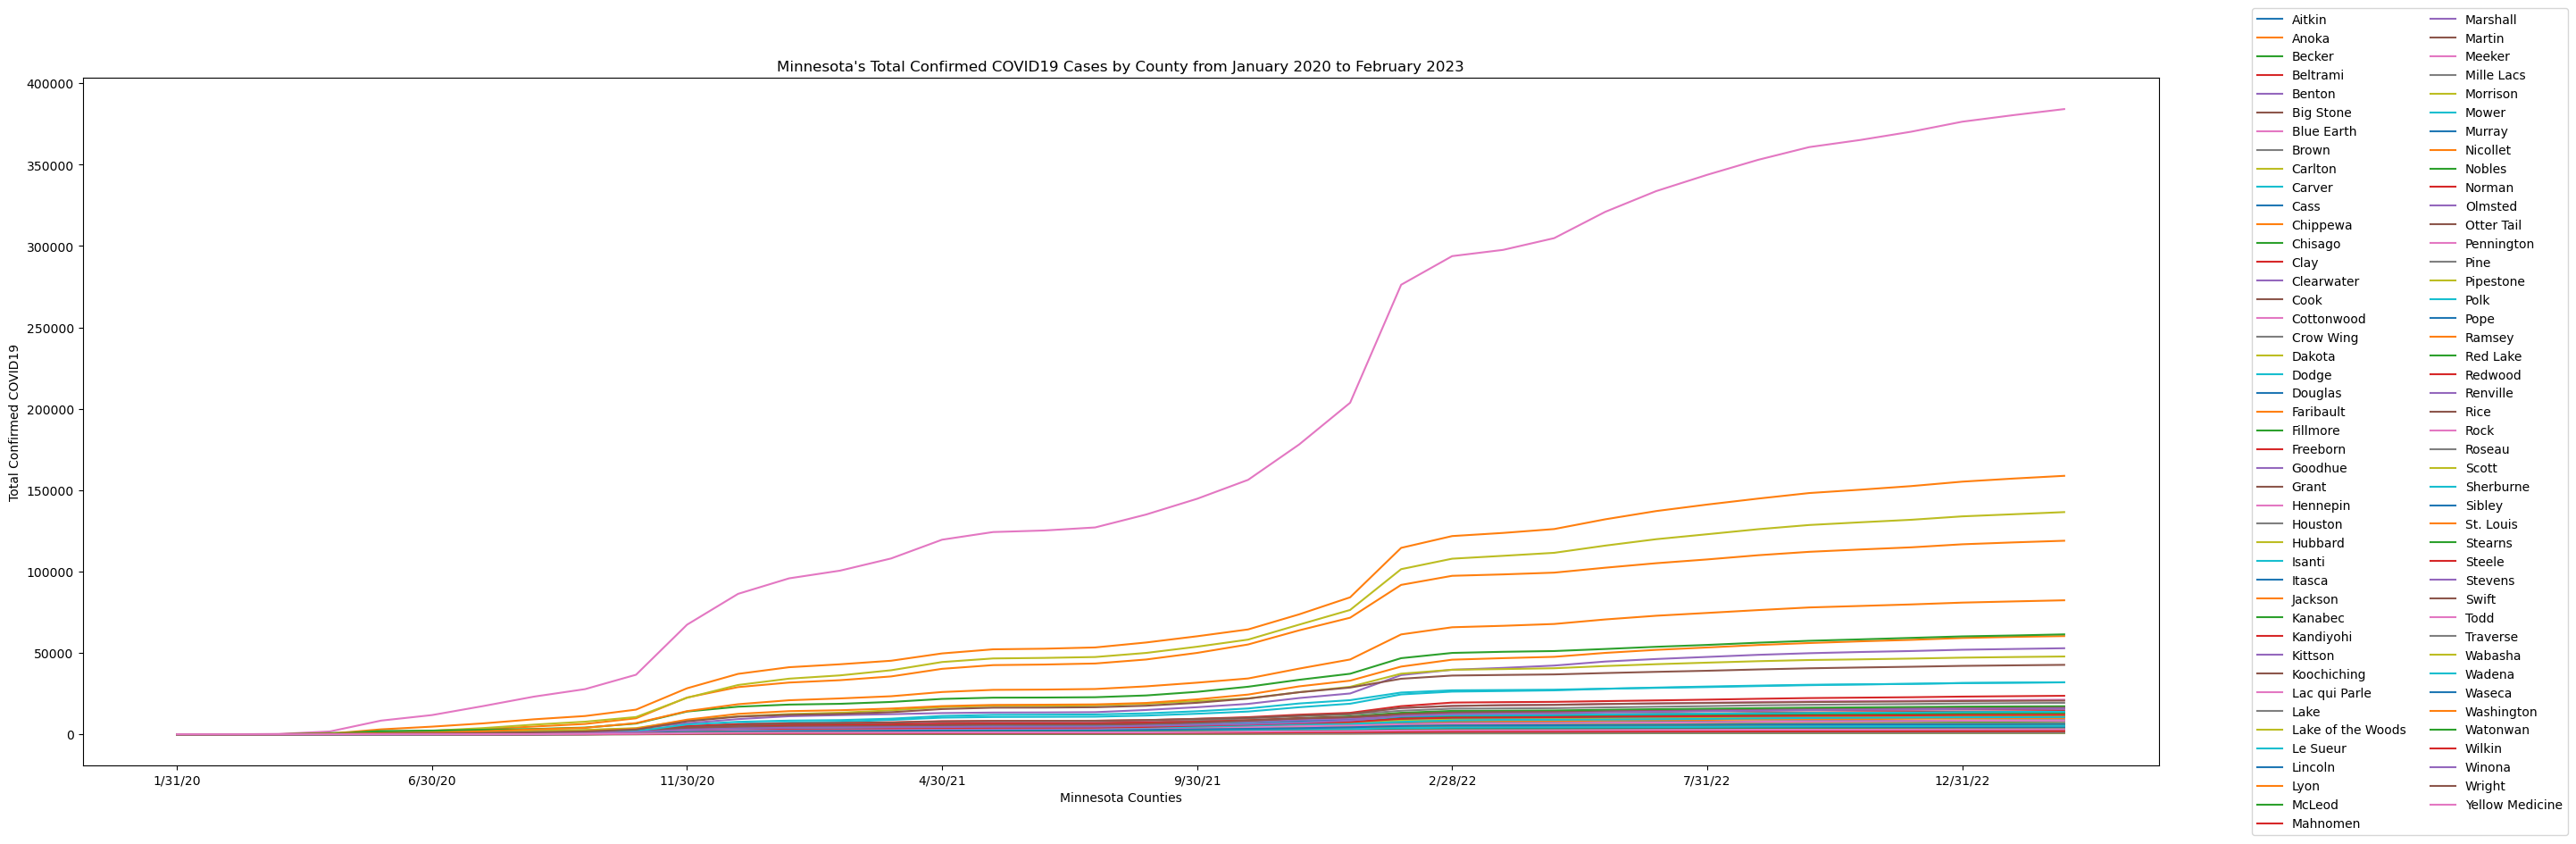

In [90]:
Minnesota_df.plot(x="timepoints", y=["Aitkin", "Anoka", "Becker", "Beltrami", "Benton", "Big Stone", "Blue Earth", "Brown", "Carlton", "Carver", "Cass", "Chippewa", "Chisago", "Clay", "Clearwater", "Cook", "Cottonwood", "Crow Wing", "Dakota", "Dodge", "Douglas", "Faribault", "Fillmore", "Freeborn", "Goodhue", "Grant", "Hennepin", "Houston", "Hubbard", "Isanti", "Itasca", "Jackson", "Kanabec", "Kandiyohi", "Kittson", "Koochiching", "Lac qui Parle", "Lake", "Lake of the Woods", "Le Sueur", "Lincoln", "Lyon", "McLeod", "Mahnomen", "Marshall", "Martin", "Meeker", "Mille Lacs", "Morrison", "Mower", "Murray", "Nicollet", "Nobles", "Norman", "Olmsted", "Otter Tail", "Pennington", "Pine", "Pipestone", "Polk", "Pope", "Ramsey", "Red Lake", "Redwood", "Renville", "Rice", "Rock", "Roseau", "Scott", "Sherburne", "Sibley", "St. Louis", "Stearns", "Steele", "Stevens", "Swift", "Todd", "Traverse", "Wabasha", "Wadena", "Waseca", "Washington", "Watonwan", "Wilkin", "Winona", "Wright", "Yellow Medicine"], kind="line", figsize=(30,10))
plt.xlabel("Minnesota Counties")
plt.ylabel("Total Confirmed COVID19")
plt.legend(loc='right', bbox_to_anchor=(1.2, 0.5), ncol=2)
plt.title("Minnesota's Total Confirmed COVID19 Cases by County from January 2020 to February 2023")

Text(0.5, 1.0, "Minnesota's Top Five Counties' Total Confirmed COVID19 Cases from January 2020 to February 2023")

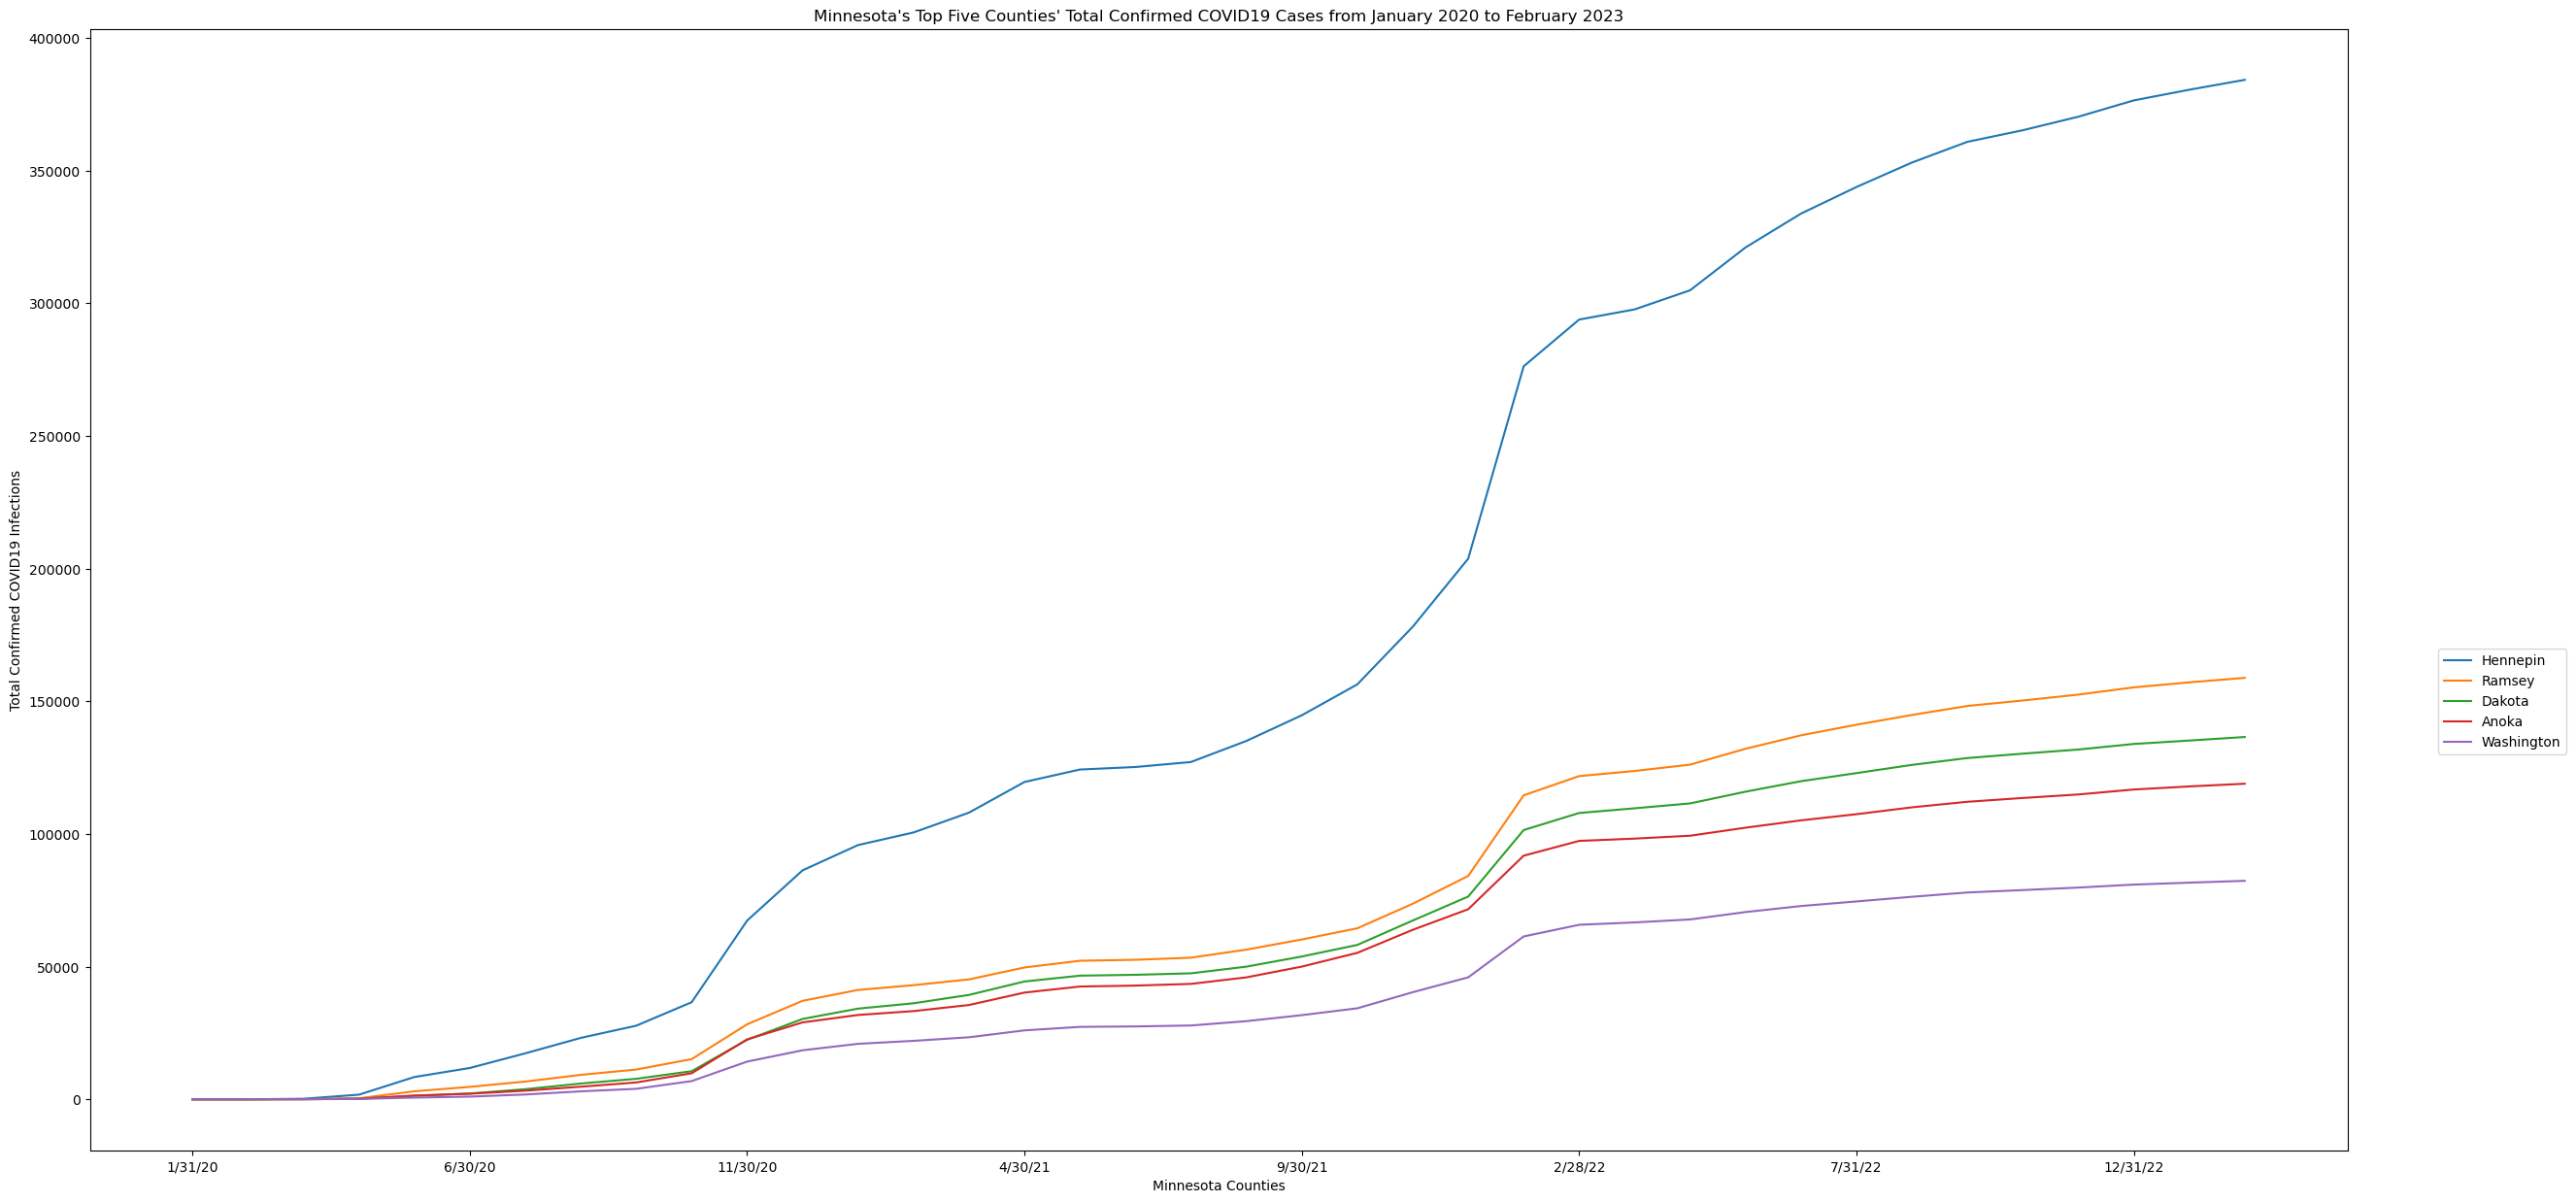

In [100]:
Minnesota_df.plot(x="timepoints", y=["Hennepin", "Ramsey", "Dakota", "Anoka", "Washington"], kind="line", figsize=(30,15))
plt.xlabel("Minnesota Counties")
plt.ylabel("Total Confirmed COVID19 Infections")
plt.legend(loc='right', bbox_to_anchor=(1.1, 0.4), ncol=1)
plt.title("Minnesota's Top Five Counties' Total Confirmed COVID19 Cases from January 2020 to February 2023")

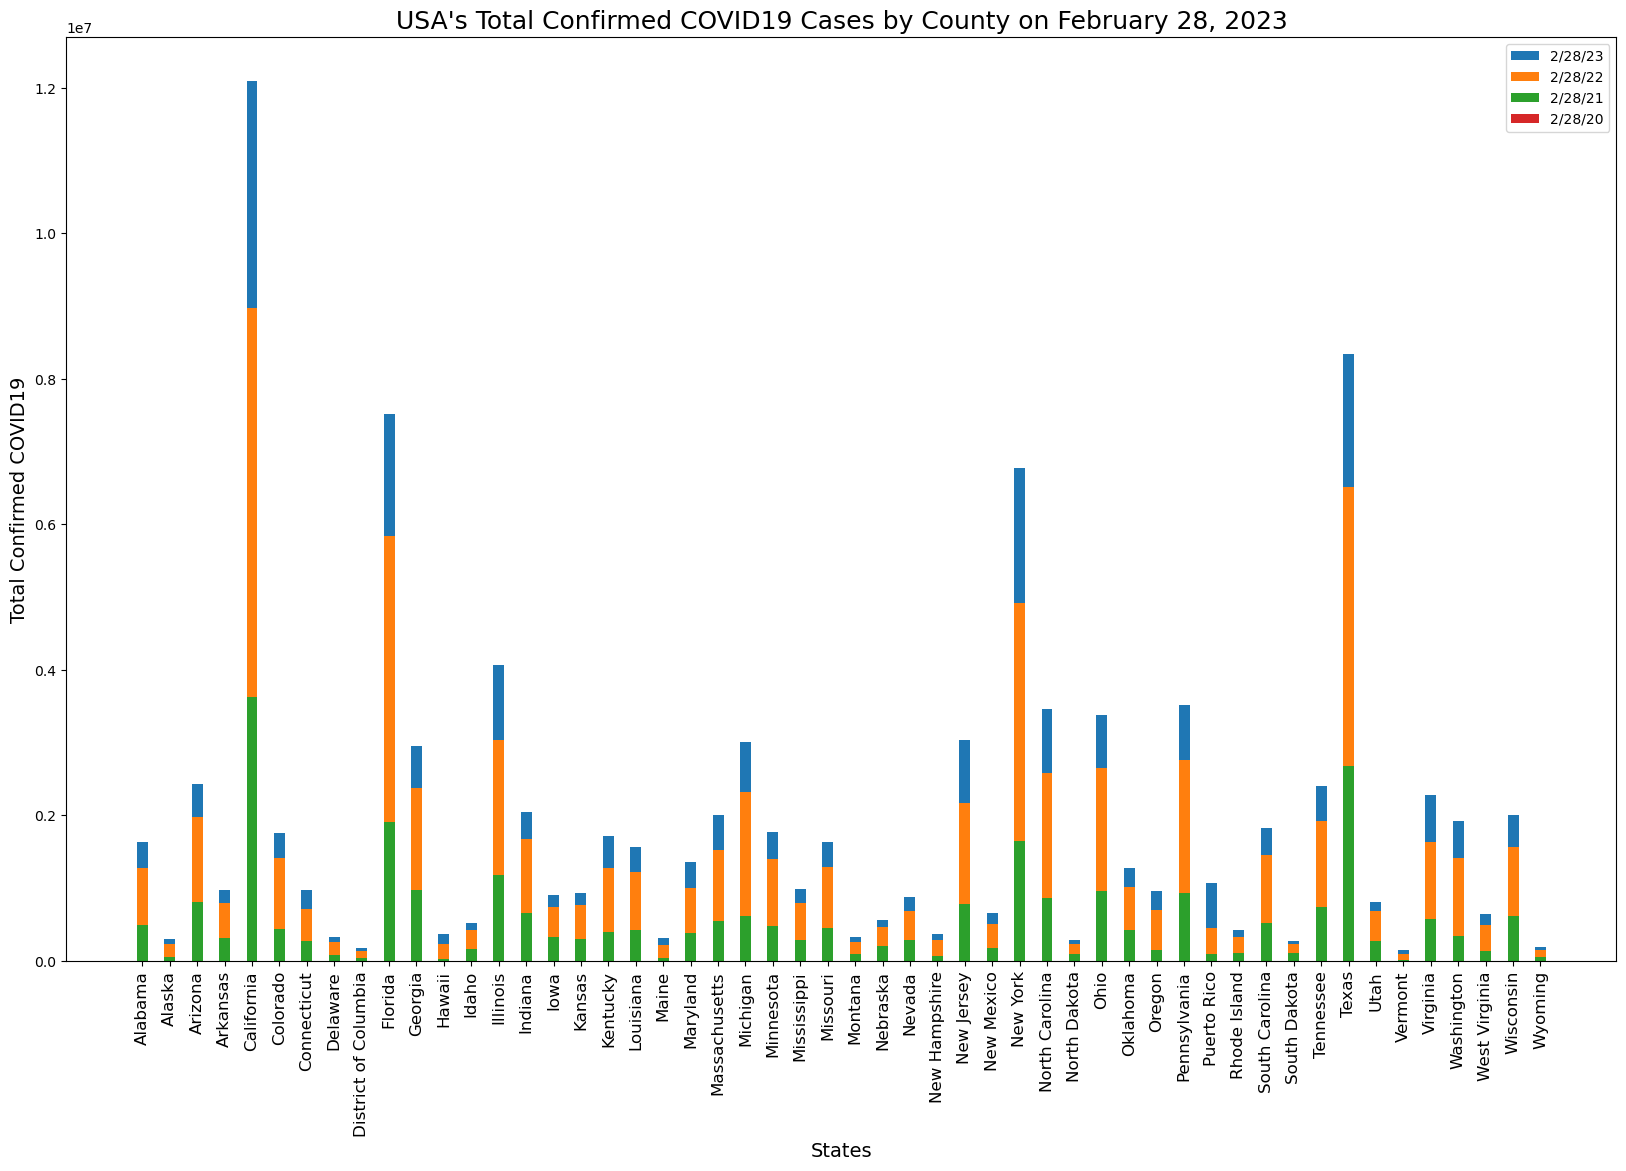

In [44]:
# Adjust size of bar chart
plt.figure(figsize=(20, 12))

# Plot running total of all Wisconsin counties
bar_width = 0.4  # Set the width of the bars for better visibility
plt.bar(USA_rollingCOVID19totalINFECTIONSperSTATE_df["Province_State"], USA_rollingCOVID19totalINFECTIONSperSTATE_df["2/28/23"], label='2/28/23', width=bar_width)
plt.bar(USA_rollingCOVID19totalINFECTIONSperSTATE_df["Province_State"], USA_rollingCOVID19totalINFECTIONSperSTATE_df["2/28/22"], label='2/28/22', width=bar_width)
plt.bar(USA_rollingCOVID19totalINFECTIONSperSTATE_df["Province_State"], USA_rollingCOVID19totalINFECTIONSperSTATE_df["2/28/21"], label='2/28/21', width=bar_width)
plt.bar(USA_rollingCOVID19totalINFECTIONSperSTATE_df["Province_State"], USA_rollingCOVID19totalINFECTIONSperSTATE_df["2/28/20"], label='2/28/20', width=bar_width)

# Add and format labels
plt.xlabel("States", fontsize=14)
plt.xticks(rotation=90, fontsize=12)  # Rotate x-axis ticks for easier reading
plt.ylabel("Total Confirmed COVID19", fontsize=14)
plt.title("USA's Total Confirmed COVID19 Cases by County on February 28, 2023", fontsize=18)

# Add a legend
plt.legend()

# Show the plot
plt.show()

Text(0.5, 1.0, 'Top Five States with Highest Total Confirmed COVID19 Cases from January 2020 to February 2023')

<Figure size 5000x10000 with 0 Axes>

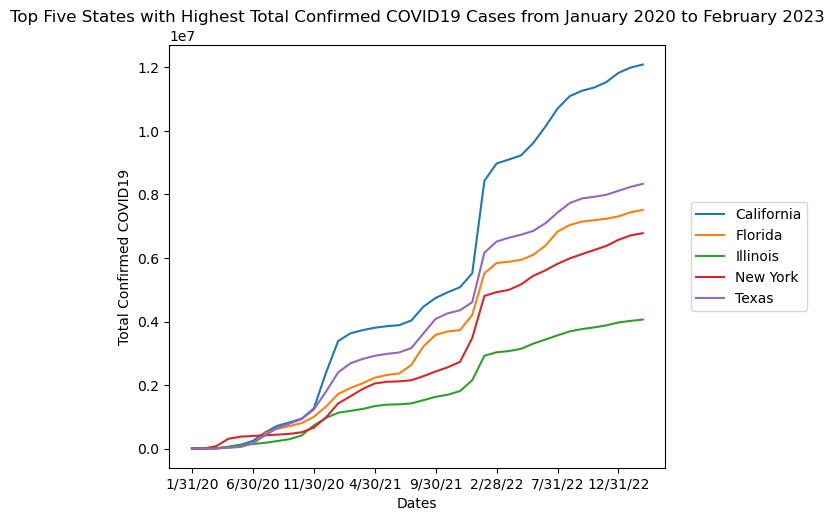

In [ ]:
#Limit this one to top states with the most COVID infections
# Increase size of graph
plt.figure(figsize=(50, 100))
# Using data output from Micah's example with modifications to dates
states_yearly_df.plot(x="Timepoints", y=["California", "Florida", "Illinois", "New York", "Texas"])
# Add line graph titles
plt.xlabel("Dates")
plt.ylabel("Total Confirmed COVID19")

# Adjust the bottom margin to make space for the legend
plt.subplots_adjust(bottom=0.0)


plt.legend(loc='right', bbox_to_anchor=(1.3, 0.5), ncol=1)
plt.title("Top Five States with Highest Total Confirmed COVID19 Cases from January 2020 to February 2023")


Text(0.5, 1.0, 'Total Confirmed COVID19 Cases by State from January 2020 to February 2023')

<Figure size 5000x10000 with 0 Axes>

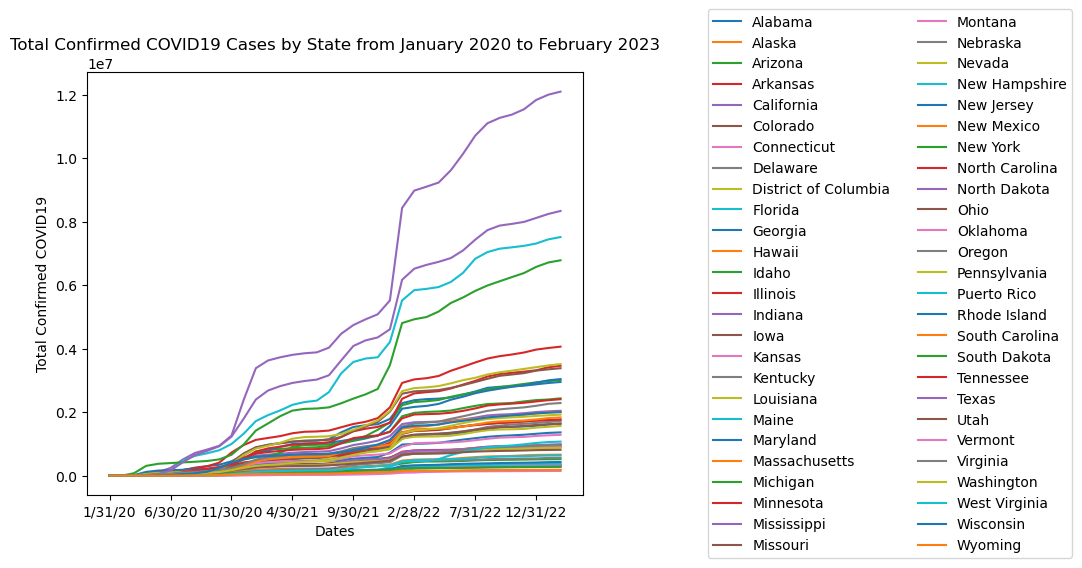

In [ ]:
#Mysee
# Increase size of graph
plt.figure(figsize=(50, 100))
# Using data output from Micah's example with modifications to dates
states_yearly_df.plot(x="Timepoints", y=["Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado", "Connecticut", "Delaware", "District of Columbia", "Florida", "Georgia", "Hawaii", "Idaho", "Illinois", "Indiana", "Iowa", "Kansas", "Kentucky", "Louisiana", "Maine", "Maryland", "Massachusetts", "Michigan", "Minnesota", "Mississippi", "Missouri", "Montana", "Nebraska", "Nevada", "New Hampshire", "New Jersey", "New Mexico", "New York", "North Carolina", "North Dakota", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Puerto Rico", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Vermont", "Virginia", "Washington", "West Virginia", "Wisconsin", "Wyoming"])
# Add line graph titles
plt.xlabel("Dates")
plt.ylabel("Total Confirmed COVID19")

# Adjust the bottom margin to make space for the legend
plt.subplots_adjust(bottom=0.0)


plt.legend(loc='right', bbox_to_anchor=(2.0, 0.5), ncol=2)
plt.title("Total Confirmed COVID19 Cases by State from January 2020 to February 2023")

# If time permits, color code each line by region and fromhighest population density to lowest population density within region.


In [ ]:
#Micah

In [ ]:
#Micah